In [ ]:
! pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 27.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=9013087a8bdb37e03f3186c34c8c5d72f1555045f1acb31f1c590c6295fd48ab
  Stored in directory: /root/.cache/pip/wheels/e2/a5/92/2c80d1928

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text          # needed for loading bert from hub
from official.nlp import optimization   # to create AdamW optimizer

from matplotlib import pyplot as plt

tf.get_logger().setLevel('ERROR')
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from preprocessing import raw_ds

AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 256
BATCH_SIZE = 32

In [ ]:
def gen(name='train'):
    for newsID, label in raw_ds[name]:
        titles = ' '.join([raw_ds['news'][i][0] for i in newsID])
        contents = ' '.join([raw_ds['news'][i][1] for i in newsID])
        yield (titles, contents), label

train_ds = tf.data.Dataset.from_generator(
    gen, output_signature=(
        tf.TensorSpec(shape=(2,), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
valid_ds = tf.data.Dataset.from_generator(
    lambda: gen('valid'), output_signature=(
        tf.TensorSpec(shape=(2,), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_ds, valid_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
num_train = train_ds.reduce(0, lambda x, _: x + 1).numpy()
num_valid = valid_ds.reduce(0, lambda x, _: x + 1).numpy()
num_train, num_valid

(224, 25)

In [ ]:
print(list(train_ds.take(1))[0][0].numpy().shape)
list(train_ds.take(1))[0][1]

(32, 2)


<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1])>

In [ ]:
from model import bert

tfhub_handle_encoder, tfhub_handle_preprocess = bert.load_handle()

BERT model selected           : https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_zh_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['航天军工改制', '复旦大小']
text_preprocessed = bert_preprocess_model(text_test)
print('preprocess:')
print(f'\tKeys       : {list(text_preprocessed.keys())}')
print(f'\tShape      : {text_preprocessed["input_word_ids"].shape}')
print(f'\tWord Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'\tInput Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'\tType Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

bert_results = bert_encoder(text_preprocessed)
print('encoder:')
print(f'\tLoaded BERT: {tfhub_handle_encoder}')
print(f'\tPooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'\tPooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'\tSequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'\tSequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

preprocess:
	Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
	Shape      : (2, 128)
	Word Ids   : [ 101 5661 1921 1092 2339 3121 1169  102    0    0    0    0]
	Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
	Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
encoder:
	Loaded BERT: https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4
	Pooled Outputs Shape:(2, 768)
	Pooled Outputs Values:[ 0.9991402   0.99678487  0.99997956  0.8220263   0.8629581  -0.18127698
  0.2989392  -0.75357944  0.9343412  -0.9979432   0.9999949   0.9999995 ]
	Sequence Outputs Shape:(2, 128, 768)
	Sequence Outputs Values:[[-0.20063043  0.42701337  0.11472004 ...  0.14706698 -0.09249002
   0.01925648]
 [ 0.40039682  0.5484915   0.30547076 ... -0.8168349  -0.5737139
  -0.22514743]
 [ 1.6686411   0.33606082 -0.9654334  ... -0.678037    0.22344735
  -0.08616148]
 ...
 [-0.54805696  0.54071593  0.09424038 ...  0.19394213 -0.72702795
  -0.3126273 ]
 [-0.610137    0.4420386  -0.16109425 ...  0.21111499 -0.7106893
  -0.2394

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()
epochs = 5
num_train_steps = num_train * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 2.5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
title_units = 16
content_units = 64

In [ ]:
# bert_model = bert.BertModel(tfhub_handle_preprocess, tfhub_handle_encoder, title_units, content_units)
bert_model = bert.build_classifier_model(tfhub_handle_preprocess, tfhub_handle_encoder, title_units, content_units, fine_tune=False)

In [ ]:
bert_model(('航天科技集团深化军工改制', '据中国航天报报道中国航天科技集团集团公司董事长党组书记雷凡培日前在集团总部述职会上透露当前集团公司正在按中央要求深化国有企业改革'))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.18972214]], dtype=float32)>

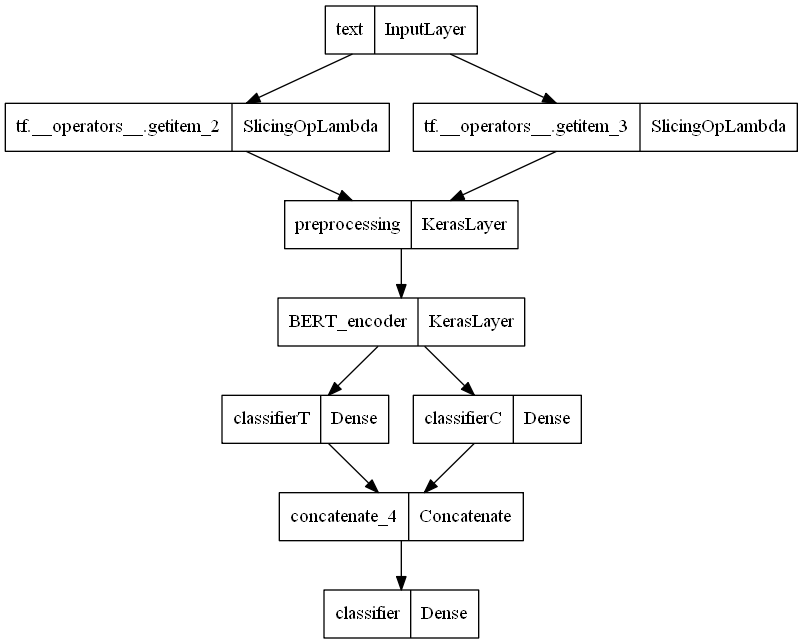

In [ ]:
from keras.utils import plot_model

os.environ["PATH"] += os.pathsep + 'D:/Graphviz/2.38/bin/'
plot_model(bert_model, to_file='model/structure.png', dpi=96)

In [ ]:
def build_classifier_model(title_units, content_units, fine_tune=True):
    text_input = tf.keras.layers.Input(shape=(2,), dtype=tf.string, name='text')
    title = text_input[:, 0]
    content = text_input[:, 1]
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    # encoder_inputs = preprocessing_layer(text_input)
    encoder_inputs_title = preprocessing_layer(title)
    encoder_inputs_content = preprocessing_layer(content)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=not fine_tune, name='BERT_encoder')
    # outputs = encoder(encoder_inputs)
    outputs_title = encoder(encoder_inputs_title)
    outputs_content = encoder(encoder_inputs_content)
    # net = outputs['pooled_output']
    net_title = outputs_title['pooled_output']
    net_content = outputs_content['pooled_output']
    # net = tf.keras.layers.Dropout(0.1)(net)
    net_title = tf.keras.layers.Dense(title_units, activation='relu', name='classifierT')(net_title)
    net_content = tf.keras.layers.Dense(content_units, activation='relu', name='classifierC')(net_content)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.concatenate([net_title, net_content])
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)
bert_model = build_classifier_model(title_units, content_units, False)

In [ ]:
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(f'Training model with {tfhub_handle_encoder}')
history = bert_model.fit(train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4
Epoch 1/5
224/224 [==============================] - 295s 1s/step - loss: 1.7067 - binary_accuracy: 0.5360 - val_loss: 1.0398 - val_binary_accuracy: 0.5879
Epoch 2/5
224/224 [==============================] - 282s 1s/step - loss: 0.9419 - binary_accuracy: 0.5747 - val_loss: 0.8896 - val_binary_accuracy: 0.5892
Epoch 3/5
224/224 [==============================] - 280s 1s/step - loss: 0.8215 - binary_accuracy: 0.5862 - val_loss: 0.8391 - val_binary_accuracy: 0.5678
Epoch 4/5
224/224 [==============================] - 278s 1s/step - loss: 0.7828 - binary_accuracy: 0.5928 - val_loss: 0.8177 - val_binary_accuracy: 0.5804
Epoch 5/5
224/224 [==============================] - 285s 1s/step - loss: 0.7694 - binary_accuracy: 0.5977 - val_loss: 0.8194 - val_binary_accuracy: 0.5917


In [ ]:
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(f'Training model with {tfhub_handle_encoder}')
history = bert_model.fit(train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4
Epoch 1/5
224/224 [==============================] - 531s 2s/step - loss: 0.9862 - binary_accuracy: 0.5929 - val_loss: 0.6867 - val_binary_accuracy: 0.6332
Epoch 2/5
224/224 [==============================] - 488s 2s/step - loss: 0.6665 - binary_accuracy: 0.6341 - val_loss: 0.7435 - val_binary_accuracy: 0.6432
Epoch 3/5
224/224 [==============================] - 490s 2s/step - loss: 0.6556 - binary_accuracy: 0.6686 - val_loss: 0.6909 - val_binary_accuracy: 0.6432
Epoch 4/5
224/224 [==============================] - 487s 2s/step - loss: 0.6479 - binary_accuracy: 0.7202 - val_loss: 0.8713 - val_binary_accuracy: 0.6658
Epoch 5/5
224/224 [==============================] - 484s 2s/step - loss: 0.5603 - binary_accuracy: 0.7654 - val_loss: 0.9940 - val_binary_accuracy: 0.6495


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


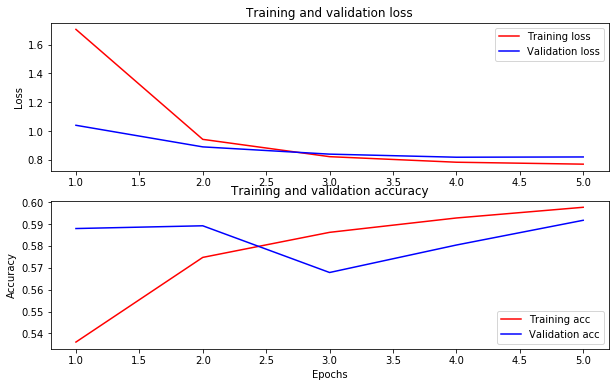

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
def plot_history(history_dict):
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


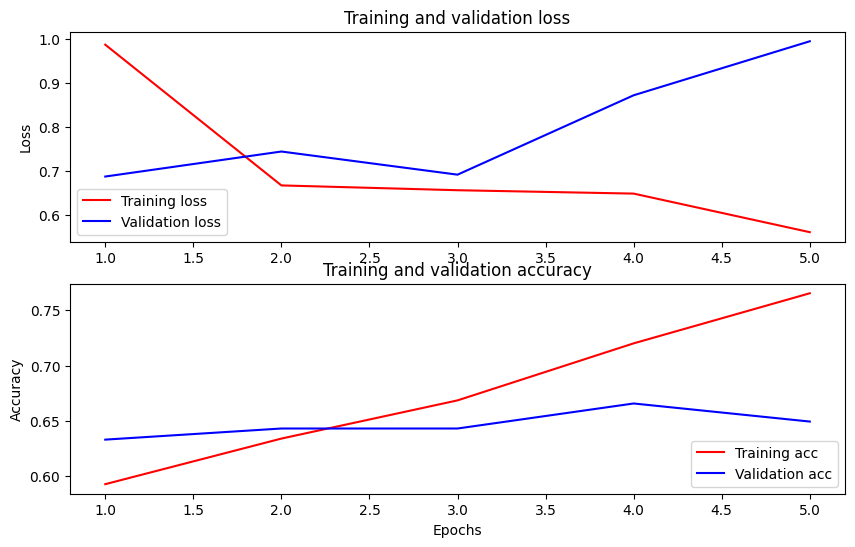

In [ ]:
plot_history(history.history)